In [5]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
path = "./Images/Images/"
annot = "./Airplanes_Annotations/Airplanes_Annotations/"

airplane_688.jpg


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\422160079.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\422160079.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\422160079.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")[2

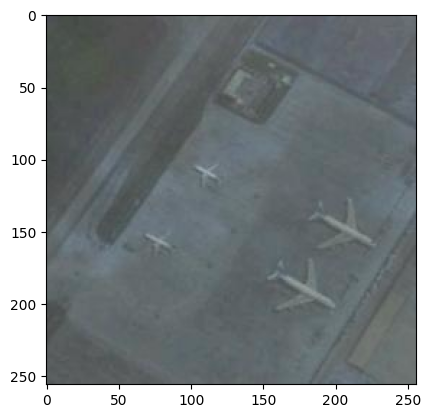

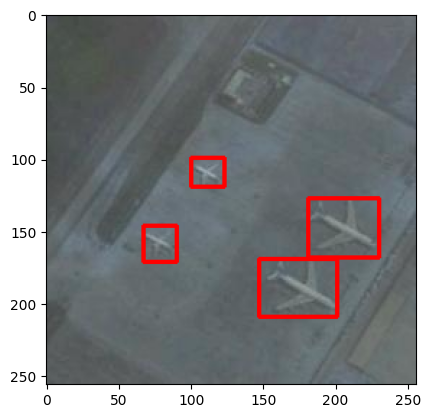

In [3]:
Index=688
filename = "airplane_"+str(Index)+".jpg"
print(filename)
img = cv2.imread(os.path.join(path,filename))
df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
plt.imshow(img)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

To impliment selective search we use cv2 library. to get more insight of it you can follow this link

In [7]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

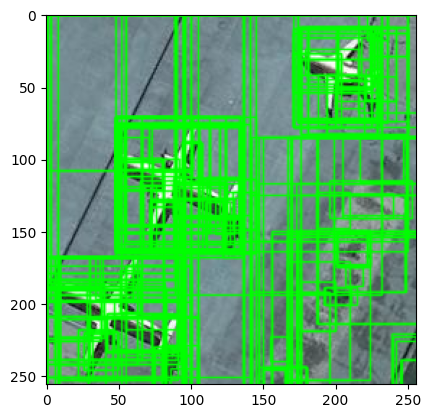

In [5]:
im = cv2.imread(os.path.join(path, "airplane_001.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h),(0, 255, 0), 1, cv2.LINE_AA)\
    # print(x,y,w,h)

plt.figure()
plt.imshow(imOut)

In [6]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**
Training data here is prepared according to following scheme:-   
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.   
b) And boxes with relative low IoU 0.3 are taken to be negative examples.  
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224.
Note- Original paper also talk about warping but as we have resized them already so there is no need of it.

In [7]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [8]:
from itertools import islice
for e, i in enumerate(islice(os.listdir(annot), 100)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            image = cv2.imread(os.path.join(path, filename))
            df = pd.read_csv(os.path.join(annot, i))
            gtvalues = []
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0


            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x, y, w, h = result
                        bb2 = {'x1':x, 'x2':x + w, 'y1':y, 'y2':y + h}
                        if(gtval["x1"]<gtval["x2"] and gtval["y1"]<gtval["y2"]):
                            iou = get_iou(gtval, bb2)
                            if counter < 30:
                                if iou > 0.7:
                                    timage = imout[x:x+w,y:y+h]
                                    resized = cv2.resize(timage, (224, 224), interpolation= cv2.INTER_AREA)
                                    train_images.append(resized)
                                    train_labels.append(1)
                                    counter += 1
                            else:
                                fflag = 1
                            if falsecounter < 30:
                                if iou < 0.3:
                                    timage = imout[x:x+w, y:y+h]
                                    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                    train_images.append(resized)
                                    train_labels.append(0)
                                    falsecounter += 1
                            else:
                                bflag = 1

                    if fflag == 1 and bflag ==1:
                        print("inside")
                        flag = 1                 
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue    

C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = int(row[1][0].split(" ")[0])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = int(row[1][0].split(" ")[1])
C:\Users\20133\AppData\Local\Temp\ipykernel_11064\683557697.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = int(row[1][0].split(" ")

inside


In [9]:
X_new = np.array(train_images)
Y_new = np.array(train_labels)


In [10]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

In [17]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, classes=1000)
for layer in vgg.layers[:-2]:
    layer.trainable = False

x = vgg.get_layer('fc2')
last_output = x.output
x = tf.keras.layers.Dense(1, activation='sigmoid')(last_output)
model = tf.keras.Model(vgg.input, x)
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()
model.fit(X_new, Y_new, batch_size=64, epochs=3, verbose=1, validation_split=.05, shuffle=True)

In [13]:
model.save('model_train.keras')

In [8]:
new_model = tf.keras.models.load_model('model_train.keras')

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 1s 1s/step
0 [[0.0225194]]
1/1 [==============================] - 0s 273ms/step
1 [[0.956699]]
1/1 [==============================] - 0s 258ms/step
2 [[0.87538356]]
1/1 [==============================] - 0s 251ms/step
3 [[0.0109893]]
1/1 [==============================] - 0s 243ms/step
4 [[0.69090486]]
1/1 [==============================] - 0s 264ms/step
5 [[0.01843212]]
1/1 [==============================] - 0s 232ms/step
6 [[0.26651713]]
1/1 [==============================] - 0s 238ms/step
7 [[0.16090856]]
1/1 [==============================] - 0s 256ms/step
8 [[0.3987839]]
1/1 [==============================] - 0s 250ms/step
9 [[0.7639154]]
1/1 [==============================] - 0s 249ms/step
10 [[0.28639373]]
1/1 [==============================] - 0s 249ms/step
11 [[0.01704835]]
1/1 [==============================] - 0s 259ms/step
12 [[0.71658933]]
1/1 [==============================] - 0s 218ms/step
13 [[0.0021489]]
1/1 [=====================

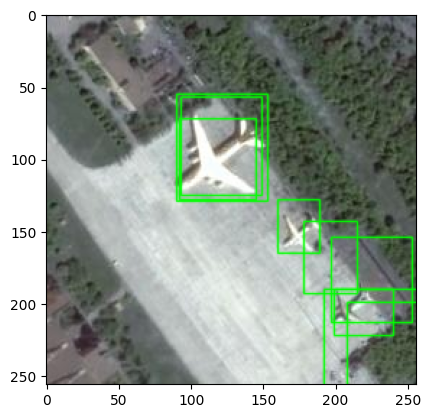

In [9]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_449.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imOut[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = new_model.predict(resized)
    print(e,out)
    # if(out[0][0]<out[0][1]):
    if(out[0][0]>0.85):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)